# Connecting Kaggle API

In [ ]:
!pip install kaggle

In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [3]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# Importing Every Library

In [4]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings
from tqdm.notebook import tqdm
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Loading Data

## Images

In [6]:
IMG_PATH = '/content/Images'

In [7]:
IMAGE_SIZE = 224

## Captions

In [8]:
df_caption = pd.read_csv('/content/captions.txt')

In [9]:
df_caption

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


# Visualizing Data

In [10]:
def readImg(img_path, IMAGE_SIZE=224):
  img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb')
  img_array = img_to_array(img)
  img = img_array / 255.

  return img

In [11]:
def visual_img(df_caption):
  temp = df_caption.reset_index(drop = True)
  plt.figure(figsize = (20,20))
  n = 0

  for i in range(9):
    n+=1
    plt.subplot(3,3, n)
    img_path = IMG_PATH + "/"+ f'{temp.image[i]}'
    img = readImg(img_path)

    plt.imshow(img)

    plt.title("\n".join(wrap(temp.caption[i], 20)))
    plt.axis('off')


In [12]:
visual_img(df_caption.sample(9))

Output hidden; open in https://colab.research.google.com to view.

# Loading VGG16

In [41]:
model = VGG16()

In [42]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# no need of output layer

In [43]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

# Feature Extraction Of Images Using VGG16

In [44]:
features = {}

for img_name in tqdm(os.listdir(IMG_PATH)):
    img_path = IMG_PATH + '/' + img_name

    image = load_img(img_path, target_size=(224, 224))

    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)

    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

# Loading Captions

In [45]:
def text_preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = "startSeq " + text + " endSeq"
    return text

In [46]:
df_caption['caption'] = df_caption['caption'].apply(text_preprocess)

# Mapping Each Image With Its Caption

In [47]:
captions_dict = {}

for _, row in tqdm(df_caption.iterrows(), total=len(df_caption)):
    img_name = row['image']
    caption_text = row['caption']

    # Extract image ID by removing file extension
    img_id = img_name.split('.')[0]

    # Add image_id to dictionary if not present
    if img_id not in captions_dict:
        captions_dict[img_id] = []

    # Append the caption to the list
    captions_dict[img_id].append(caption_text)


  0%|          | 0/40455 [00:00<?, ?it/s]

In [48]:
len(captions_dict)

8091

# ALL Captions Stored Seperately

In [49]:
captions = df_caption['caption']

In [50]:
captions = captions.tolist()

In [51]:
len(captions)

40455

In [52]:
captions[:10]

['startSeq startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq endSeq',
 'startSeq startseq a girl going into a wooden building endseq endSeq',
 'startSeq startseq a little girl climbing into a wooden playhouse endseq endSeq',
 'startSeq startseq a little girl climbing the stairs to her playhouse endseq endSeq',
 'startSeq startseq a little girl in a pink dress going into a wooden cabin endseq endSeq',
 'startSeq startseq a black dog and a spotted dog are fighting endseq endSeq',
 'startSeq startseq a black dog and a tricolored dog playing with each other on the road endseq endSeq',
 'startSeq startseq a black dog and a white dog with brown spots are staring at each other in the street endseq endSeq',
 'startSeq startseq two dogs of different breeds looking at each other on the road endseq endSeq',
 'startSeq startseq two dogs on pavement moving toward each other endseq endSeq']

# Tokenization On Captions

In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

In [54]:
len(tokenizer.word_index) # this is the vocab size

8780

In [55]:
vocab_size = len(tokenizer.word_index) + 1

In [56]:
max(len(caption.split()) for caption in captions) # This is the maximum length of the sequence

39

In [57]:
max_length = max(len(caption.split()) for caption in captions)

# Splitting Data

In [58]:
image_ids = list(captions_dict.keys())
split = int(len(image_ids) * 0.85)

In [29]:
split

6877

In [59]:
train = image_ids[:split]
test = image_ids[split:]

# Creating A Data Generator

In [60]:
def CustomDataGenerator(data_set, captions_dict, features, tokenizer, max_length, vocab_size, batch_size):
    # Looping through images and captions

    X1, X2, y = list(), list(), list()
    n = 0

    # Infinite Loop
    while 1:
        for key in data_set:
            n += 1
            captions = captions_dict[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Building

In [74]:
# INPUT LAYER FOR IMAGES
inputs1 = Input(shape=(4096,), name="image") # 4096 for image
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# INPUT LAYER FOR TEXTUAL DATA
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Combining 2 layers into one
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
# Output layer
outputs = Dense(vocab_size, activation='softmax')(decoder2)


In [75]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [76]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

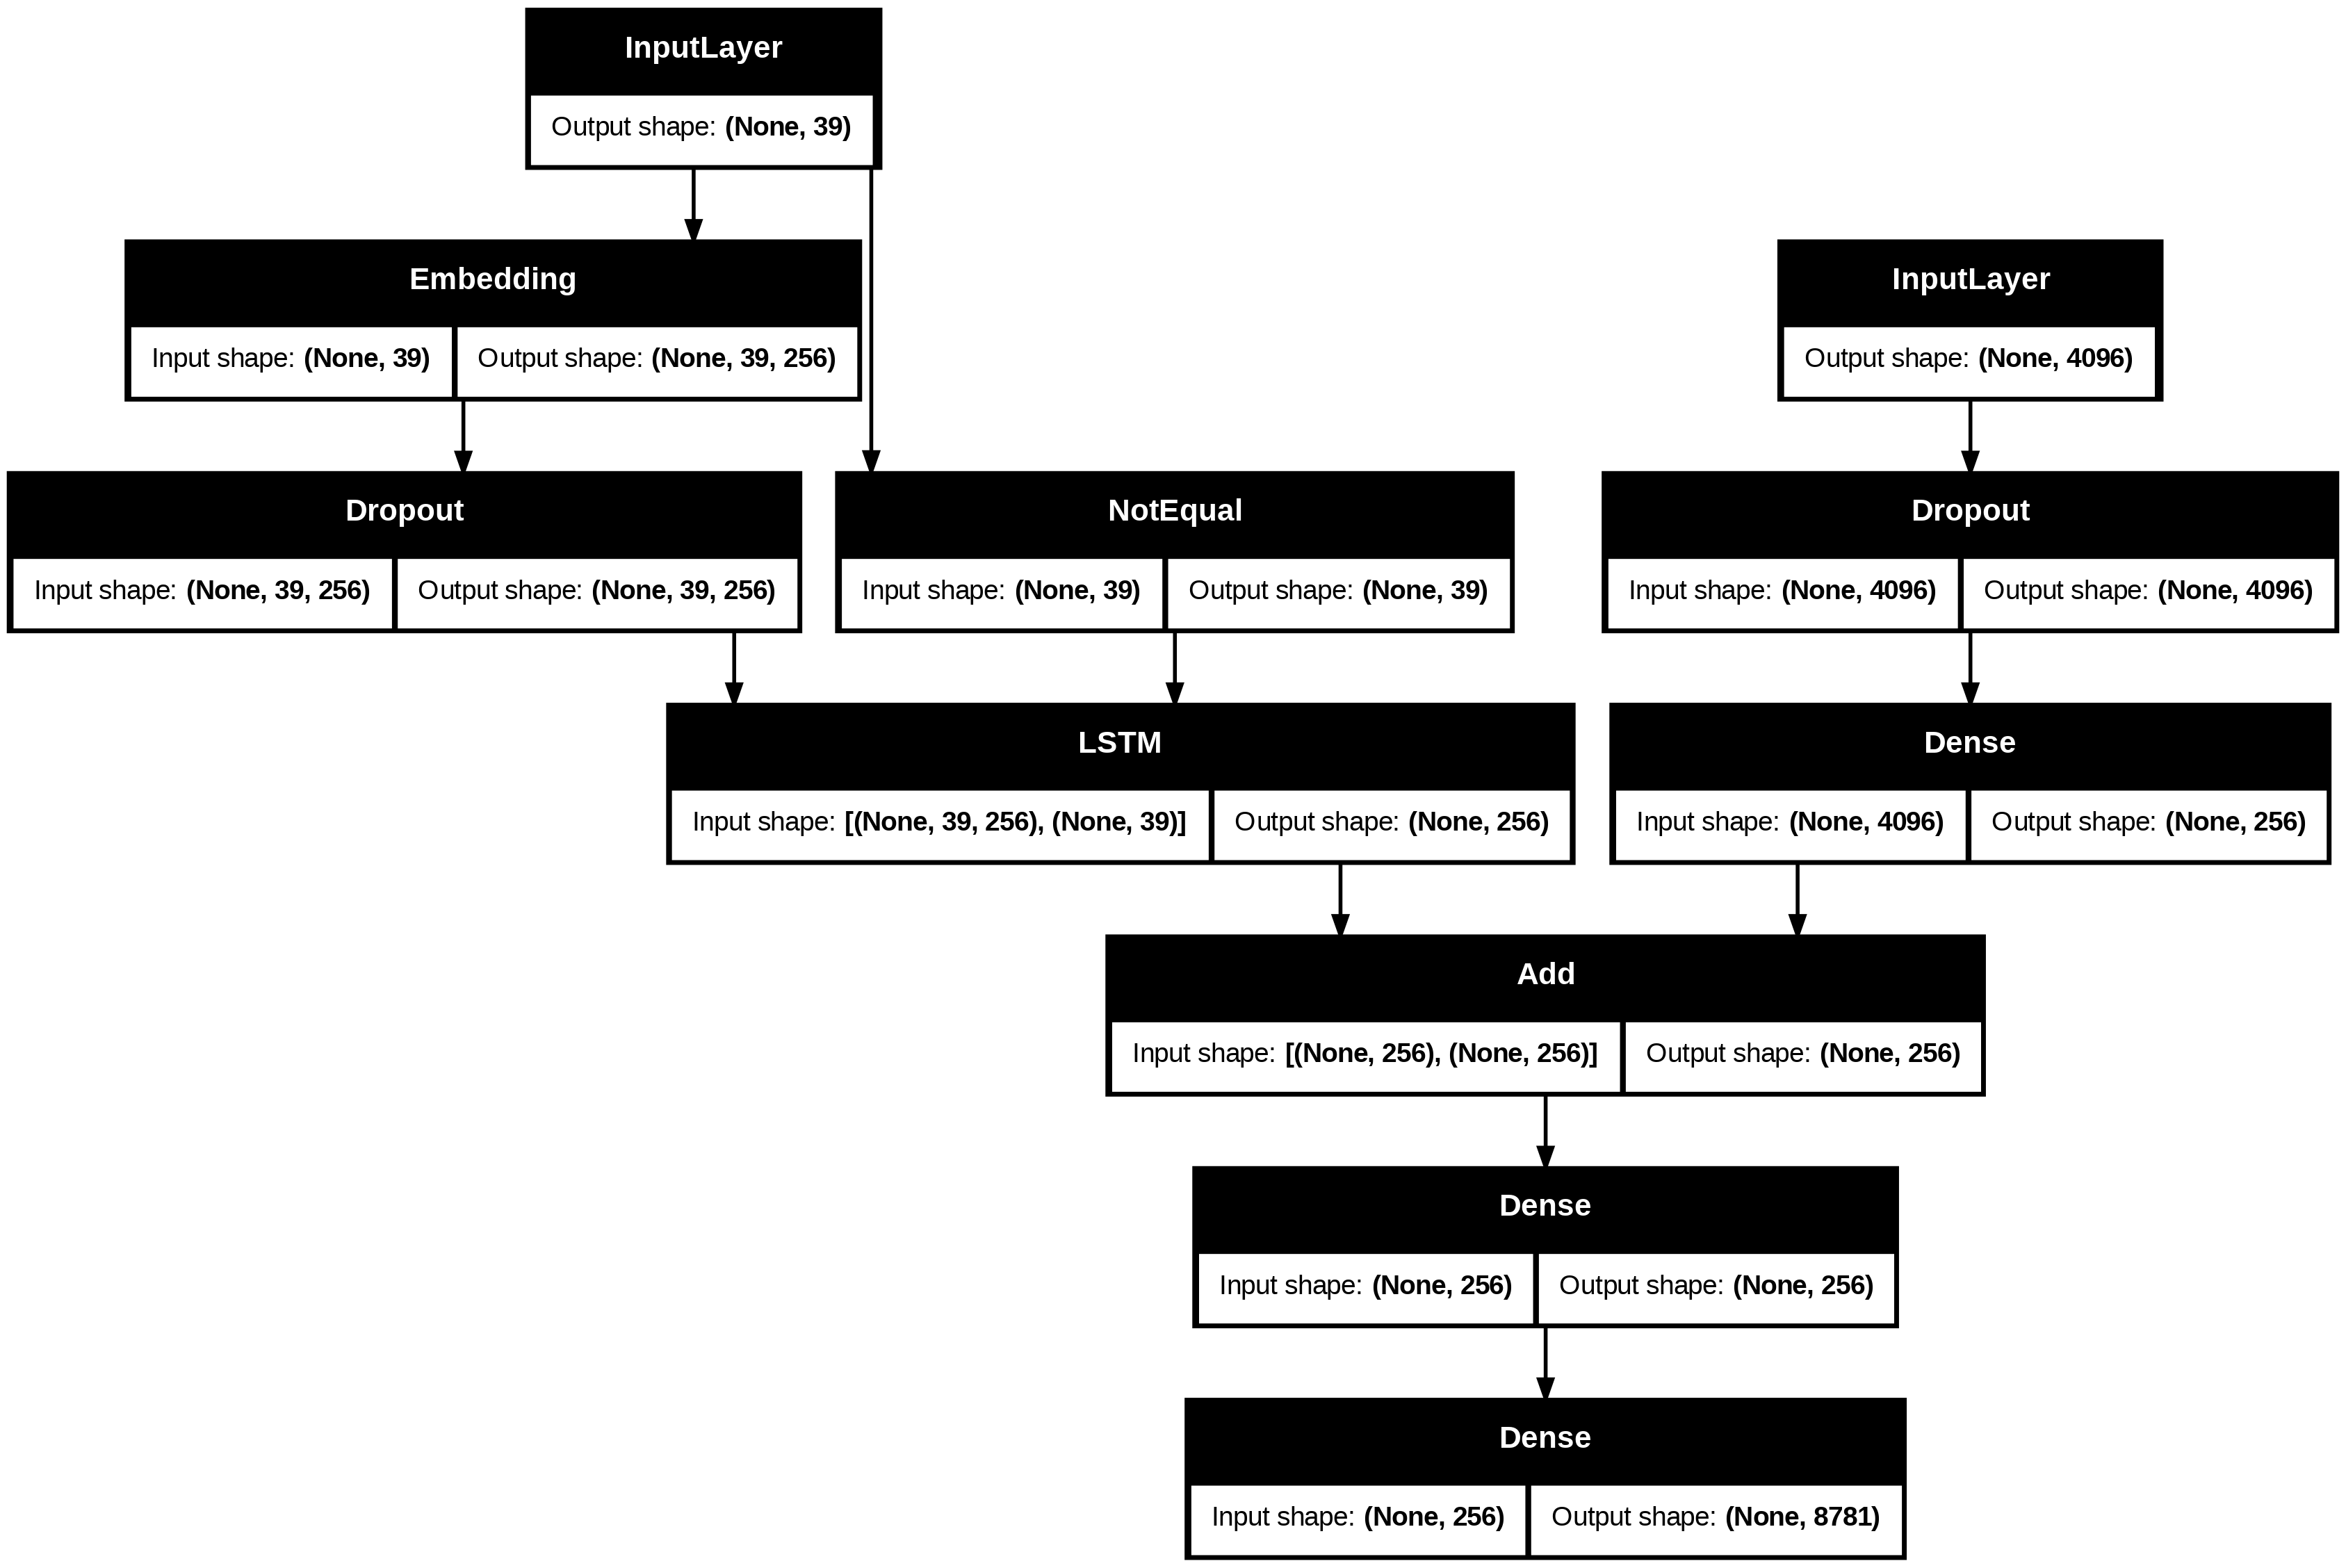

In [77]:
plot_model(model, show_shapes=True)

# Training Model

In [78]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

In [79]:
for i in range(epochs):
    generator = CustomDataGenerator(train, captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1) # This will only goes for one eppoch thats why we run a loop

214/214 ━━━━━━━━━━━━━━━━━━━━ 100s 441ms/step - loss: 4.9257
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 456ms/step - loss: 3.1601
214/214 ━━━━━━━━━━━━━━━━━━━━ 94s 437ms/step - loss: 2.7733
214/214 ━━━━━━━━━━━━━━━━━━━━ 96s 448ms/step - loss: 2.5439
214/214 ━━━━━━━━━━━━━━━━━━━━ 99s 460ms/step - loss: 2.3853
214/214 ━━━━━━━━━━━━━━━━━━━━ 110s 513ms/step - loss: 2.2672
214/214 ━━━━━━━━━━━━━━━━━━━━ 131s 612ms/step - loss: 2.1809
214/214 ━━━━━━━━━━━━━━━━━━━━ 117s 546ms/step - loss: 2.1086
214/214 ━━━━━━━━━━━━━━━━━━━━ 146s 679ms/step - loss: 2.0533
214/214 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - loss: 2.0002


214 are the steps per epoch


In [80]:
model.save("/content/model_10_2.keras")

In [82]:
# for i in range(5):
#     generator = CustomDataGenerator(train, captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
#     model.fit(generator,initial_epoch=10, epochs=15, steps_per_epoch=steps, verbose=1) # This will only goes for one eppoch thats why we run a loop

We can train it for more epochs and it will increase its performance

# Convert Model Output Into Text

In [83]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [100]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer) # converting model result into a word
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    in_text = in_text.replace('startseq', '')
    in_text = in_text.replace('endseq', '')
    return in_text


# Checking Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

actual, predicted = list(), list()

for key in tqdm(test):
    # Get reference captions
    captions = captions_dict[key]
    # Predict caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to lists
    actual.append(actual_captions)  # List of reference captions (list of lists)
    predicted.append(y_pred)        # Predicted caption (list of words)

# Compute BLEU scores ONCE after collecting all predictions
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

100%|██████████| 1214/1214 [18:33<00:00,  1.09it/s]


BLEU-1: 0.456822
BLEU-2: 0.297839
BLEU-3: 0.188847
BLEU-4: 0.113620


# Visualize Actual Vs Predicted Output

In [102]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    image_id = image_name.split('.')[0]

    if image_id not in captions_dict:
        print(f"\n❌ No captions found for '{image_id}'.")
        return
    if image_id not in features:
        print(f"\n❌ No features found for '{image_id}'.")
        return

    img_path = os.path.join(IMG_PATH, image_name)
    try:
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
    except Exception as e:
        print(f"\n❌ Error loading image: {e}")
        return

    # Display image first
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print captions in a formatted style
    print("\n" + "=" * 50)
    print(f"📷 Image ID: {image_id}")
    print("=" * 50)

    print("\n📌 **Actual Captions:**")
    for i, caption in enumerate(captions_dict[image_id], 1):
        print(f"  {i}. {caption}")

    print("\n🧠 **Predicted Caption:**")
    print("-" * 50)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(f"🔹 {y_pred}")
    print("-" * 50)


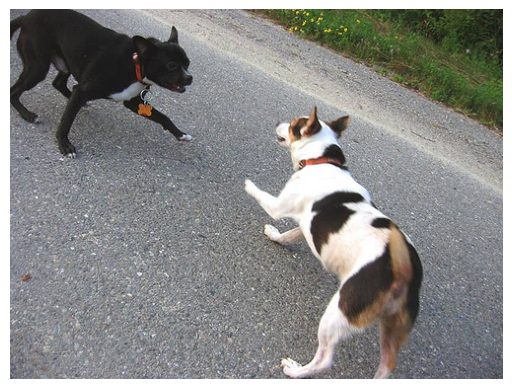


📷 Image ID: 1001773457_577c3a7d70

📌 **Actual Captions:**
  1. startSeq startseq a black dog and a spotted dog are fighting endseq endSeq
  2. startSeq startseq a black dog and a tricolored dog playing with each other on the road endseq endSeq
  3. startSeq startseq a black dog and a white dog with brown spots are staring at each other in the street endseq endSeq
  4. startSeq startseq two dogs of different breeds looking at each other on the road endseq endSeq
  5. startSeq startseq two dogs on pavement moving toward each other endseq endSeq

🧠 **Predicted Caption:**
--------------------------------------------------
🔹   two dogs play with a ball in the grass 
--------------------------------------------------


In [103]:
generate_caption("1001773457_577c3a7d70.jpg")

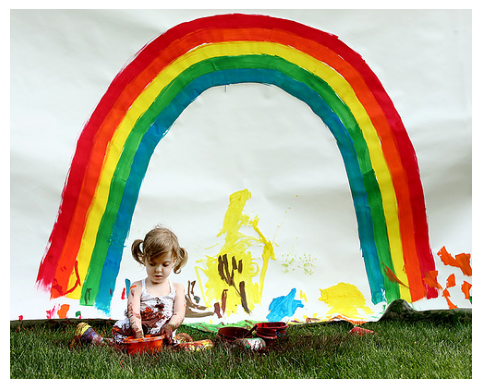


📷 Image ID: 1002674143_1b742ab4b8

📌 **Actual Captions:**
  1. startSeq startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq endSeq
  2. startSeq startseq a little girl is sitting in front of a large painted rainbow endseq endSeq
  3. startSeq startseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it endseq endSeq
  4. startSeq startseq there is a girl with pigtails sitting in front of a rainbow painting endseq endSeq
  5. startSeq startseq young girl with pigtails painting outside in the grass endseq endSeq

🧠 **Predicted Caption:**
--------------------------------------------------
🔹   a child is laying in the middle of a red tulip 
--------------------------------------------------


In [104]:
generate_caption("1002674143_1b742ab4b8.jpg")

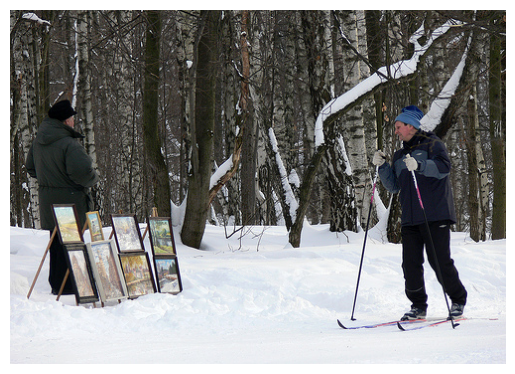


📷 Image ID: 101669240_b2d3e7f17b

📌 **Actual Captions:**
  1. startSeq startseq a man in a hat is displaying pictures next to a skier in a blue hat endseq endSeq
  2. startSeq startseq a man skis past another man displaying paintings in the snow endseq endSeq
  3. startSeq startseq a person wearing skis looking at framed pictures set up in the snow endseq endSeq
  4. startSeq startseq a skier looks at framed pictures in the snow next to trees endseq endSeq
  5. startSeq startseq man on skis looking at artwork for sale in the snow endseq endSeq

🧠 **Predicted Caption:**
--------------------------------------------------
🔹   a woman wearing a red jacket is skiing through the snow 
--------------------------------------------------


In [105]:
generate_caption("101669240_b2d3e7f17b.jpg")

# Test On New Data

In [86]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs,outputs=vgg_model.layers[-2].output)

In [101]:
image_path = '/content/dog_playing.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'  a white dog is running in the grass '

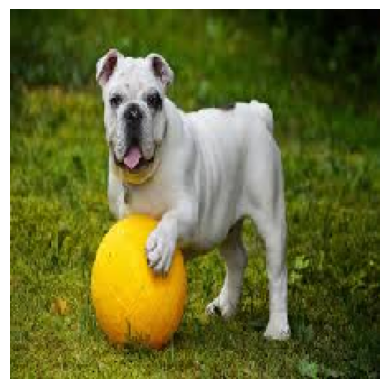

In [96]:
img = load_img('/content/dog_playing.jpg', target_size=(224, 224))
img_array = img_to_array(img)


plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()